In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvas
# allow us to re-use the framework from the src directory
import sys, os
sys.path.append(os.path.abspath(os.path.join('../')))

In [2]:
import max_ent.examples.grid_9_by_9 as G
import max_ent.examples.grid_plot as P
import max_ent.gridworld.feature as F
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from max_ent.gridworld import Directions
from max_ent.gridworld.trajectory import Trajectory
%matplotlib notebook
np.random.seed(123)

In [3]:
def plot_world(title, mdp, state_rewards, action_rewards, color_rewards,
               demo, blue_states, green_states, vmin=None, vmax=None):
    cm = plt.cm.afmhot
#     cm = plt.cm.viridis
    fsize = (4.5, 3)
    fig = plt.figure(num=title, figsize=fsize)
    spec = gridspec.GridSpec(ncols=12, nrows=2, figure=fig)
    colored = [(s, 'blue') for s in blue_states]
    colored += [(s, 'green')for s in green_states]

    ax = fig.add_subplot(spec[1, 10])
    P.plot_colors(ax, color_rewards, vmin=vmin, vmax=vmax, cmap=cm)

    ax = fig.add_subplot(spec[0, 9:12])
    P.plot_action_rewards(ax, action_rewards, vmin=vmin, vmax=vmax, cmap=cm)

    ax = fig.add_subplot(spec[:, :8])
    p = P.plot_state_values(ax, mdp.world, state_rewards, mdp.start,
                            mdp.terminal, colored, vmin=vmin, vmax=vmax, cmap=cm)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("left", size="5%", pad=0.1)
    cb = plt.colorbar(p, cax=cax)
    cb.ax.yaxis.set_ticks_position("left")

    plt.draw()
    return ax, fig

In [4]:
def config_world(blue, green, constrained_states, constrained_actions, constrained_colors, goal,
                 penalty=-50, start=[0], p_slip=0.1, dist_penalty=True, default_reward=-4):
    size = 9
    action_penalty, state_penalty, color_penalty = penalty, penalty, penalty
    goal_r = 10

    # set-up the mdp
    sf = F.DistinationStateFeature(size**2)
    af = F.DirectionFeature(Directions.ALL_DIRECTIONS)
    cf = F.ColorFeature(['No Color', 'Blue', 'Green'], 0)
    cf.set_states_color(blue, 'Blue')
    cf.set_states_color(green, 'Green')

    # Destination state penalties
    constraints = []
    sp = np.zeros(size**2)
    sp[goal] = goal_r
    for s, p in constrained_states:
        constraints.append((sf, s, p))
        sp[s] = p

    # Action penalties
    ap = {a: default_reward * (np.sqrt(a.x**2 + a.y**2) if dist_penalty else 1)
          for a in Directions.ALL_DIRECTIONS}
    p = -20
    for a in ap:
        if a in constrained_actions:
            ap[a] = p
            p *= 2

        constraints.append((af, a.idx, ap[a]))

    # Color
    cp = np.zeros(3)
    p = -30
    for c in constrained_colors:
        constraints.append((cf, c, color_penalty))
        cp[c] = p
        p /= 2

    feature_list = [sf, af, cf]
    goal = goal if isinstance(goal, list) or isinstance(
        goal, np.ndarray) else [goal]
    start = start if isinstance(start, list) or isinstance(
        start, np.ndarray) else [start]
    mdp = G.setup_mdp(size, feature_list, constraints, terminal=goal,
                    terminal_reward=goal_r, start=start, p_slip=p_slip)

    return G.Config(mdp, sp, ap, cp, blue, green)

In [5]:
def create_world(title, blue, green, cs=[], ca=[], cc=[], start=0, goal=8, vmin=-50, vmax=10):
    n_cfg = config_world(blue, green, [], [], [], goal, start=start, p_slip=0)
    n = n_cfg.mdp
    c_cfg = config_world(blue, green, cs, ca, cc, goal, start=start, p_slip=0)
    c = c_cfg.mdp

    # Generate demonstrations and plot the world
    demo1 = Trajectory([(0, 1, 1), (1, 1, 2), (2, 1, 3), (3, 1, 4), (4, 1, 5), (5, 1, 6), (6, 1, 7), (7, 1, 8)])
    demo2 = Trajectory([(0, 2, 9), (9, 2, 18), (18, 2, 27), (27, 2, 36), (36, 2, 45), (45, 2, 54), (54, 1, 55), 
                        (55, 1, 56), (56, 7, 48), (48, 7, 40), (40, 7, 32), (32, 7, 24), (24, 7, 16), (16, 7, 8)])
    vmin = -50
    vmax = 10
    ax, fig = plot_world(title, c, c_cfg.state_penalties,
           c_cfg.action_penalties, c_cfg.color_penalties,
           demo1, c_cfg.blue, c_cfg.green, vmin=vmin, vmax=vmax)  
 
    P.plot_trajectory(ax, n.world, demo1, lw=4, color='red', alpha=0.7)    
    P.plot_trajectory(ax, n.world, demo2, lw=4, color='blue', alpha=0.7) 
    
    return fig

<IPython.core.display.Javascript object>


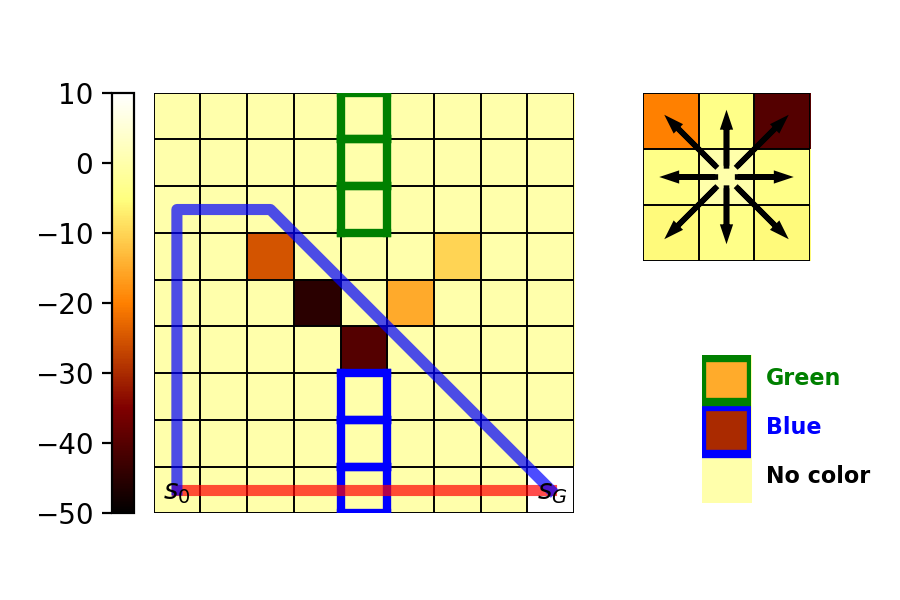

{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x7f8a684afe20>}


In [6]:
cs = [(31, -40), (39, -45), (41, -15), (47, -25), (51, -10)]  # constrained states
ca = [Directions.UP_LEFT, Directions.UP_RIGHT]  # constrained actions
cc = [1, 2]  # constrained colors
blue = [4, 13, 22]  # blue states
green = [58, 67, 76]  # green states

fig = create_world('Constrained', blue, green, cs, ca, cc)

In [8]:
# fig.savefig('example.pdf')